### Paketimporte

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns

### Vorbereitung der Daten

Preise

In [2]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

Downtime

In [3]:
df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

Kundendaten

In [4]:
df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

Vereinen der Transaktionsdaten

In [5]:
def read_regio_data(region, kind):
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "transaction_id"]], on="transaction_id"))

df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

In [6]:
# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifische Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

### Gewinn sinkt, weil Kosten steigen? → auf Regionen und Markplatz beziehen

In [10]:
df_reg_main['year_month'] = df_reg_main['year'].astype(str) + '-' + df_reg_main['month'].astype(str)

<Axes: xlabel='year_month', ylabel='profit'>

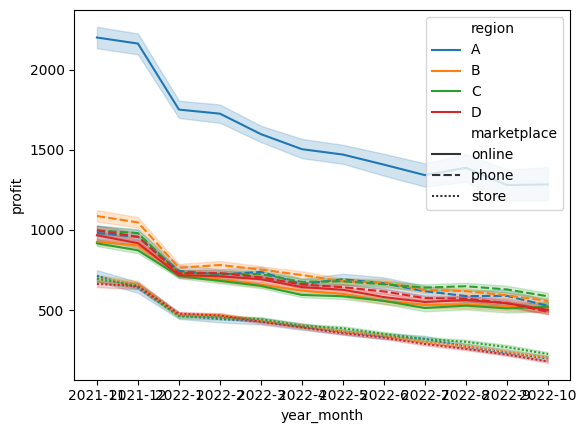

In [31]:
sns.lineplot(data=df_reg_main, x="year_month", y="profit", hue="region", style="marketplace")

<Axes: xlabel='year_month', ylabel='profit_per_unit'>

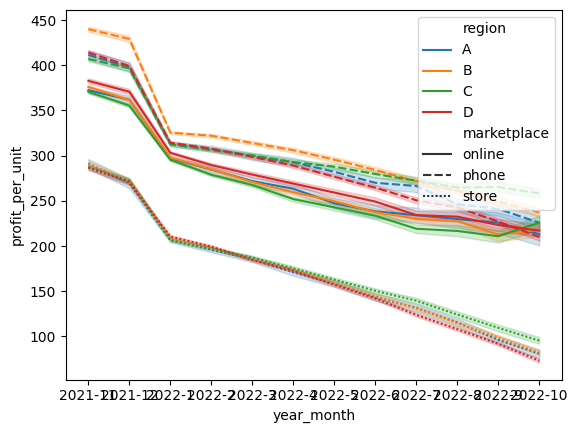

In [12]:
sns.lineplot(data=df_reg_main, x="year_month", y="profit_per_unit", hue="region", style="marketplace")

<Axes: xlabel='year_month', ylabel='cost_per_unit'>

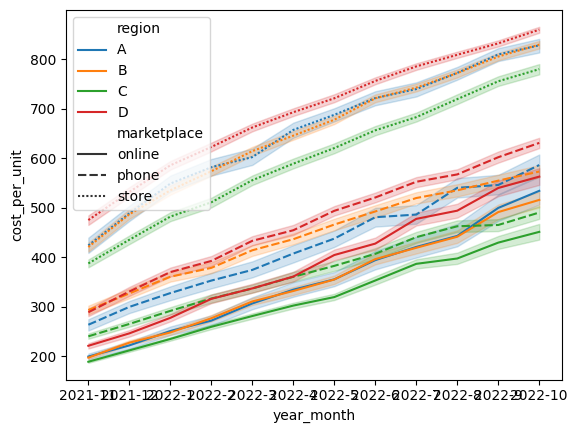

In [13]:
sns.lineplot(data=df_reg_main, x="year_month", y="cost_per_unit", hue="region", style="marketplace")

<Axes: xlabel='year_month', ylabel='price'>

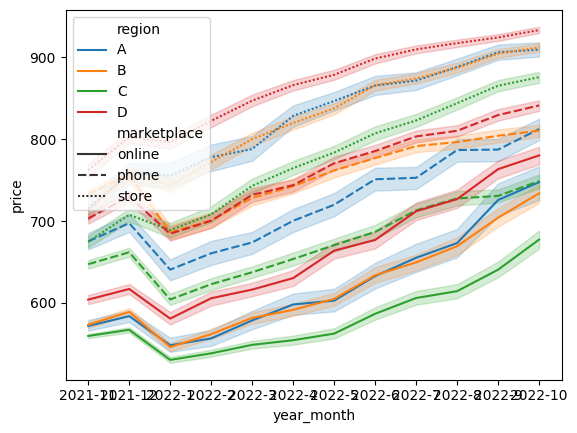

In [14]:
sns.lineplot(data=df_reg_main, x="year_month", y="price", hue="region", style="marketplace")

#### Sind Stores ineffektiv? (auf Umsatz, menge, Gewinn etc. beziehen)

<Axes: xlabel='marketplace', ylabel='amount'>

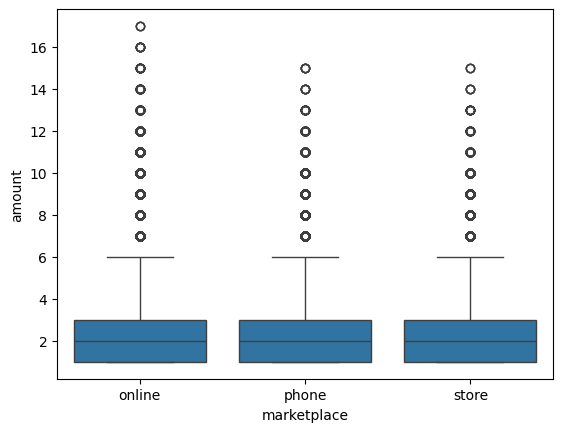

In [19]:
sns.boxplot(data=df_reg_main, x="marketplace", y="amount")

In [20]:
df_reg_main.groupby(['marketplace'])['amount'].mean()

marketplace
online    2.822527
phone     2.309044
store     2.227111
Name: amount, dtype: float64

<Axes: xlabel='marketplace', ylabel='cost_per_unit'>

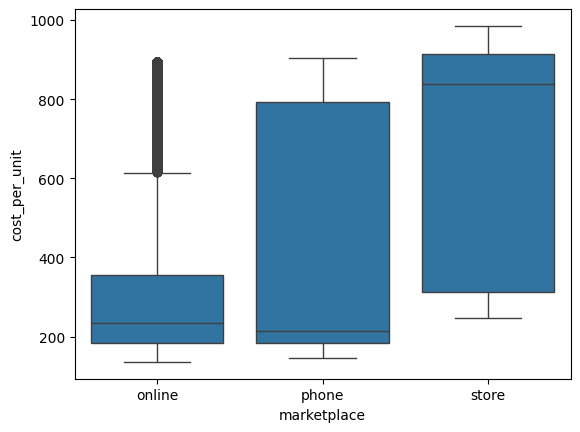

In [22]:
sns.boxplot(data=df_reg_main, x="marketplace", y="cost_per_unit")

<Axes: xlabel='marketplace', ylabel='price'>

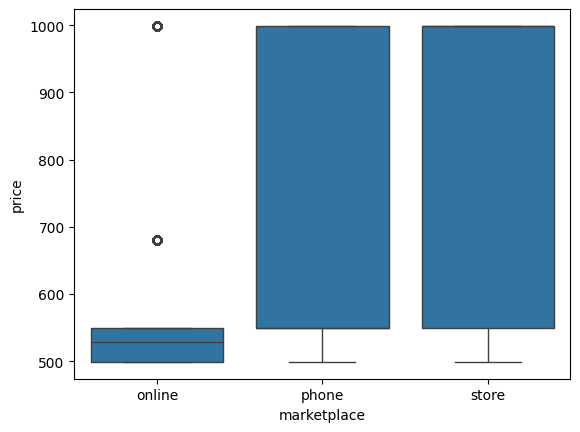

In [24]:
sns.boxplot(data=df_reg_main, x="marketplace", y="price")

In [15]:
df_reg_main.groupby(['marketplace'])['price'].mean()

marketplace
online    610.859328
phone     737.475456
store     841.121992
Name: price, dtype: float64

In [33]:
# Group by marketplace and count the number of transactions with a discount less than 1
df_reg_main.groupby(['marketplace'])['discount'].apply(lambda x: (x < 1).sum())

marketplace
online    16634
phone      8764
store      8006
Name: discount, dtype: int64

<Axes: xlabel='marketplace', ylabel='revenue'>

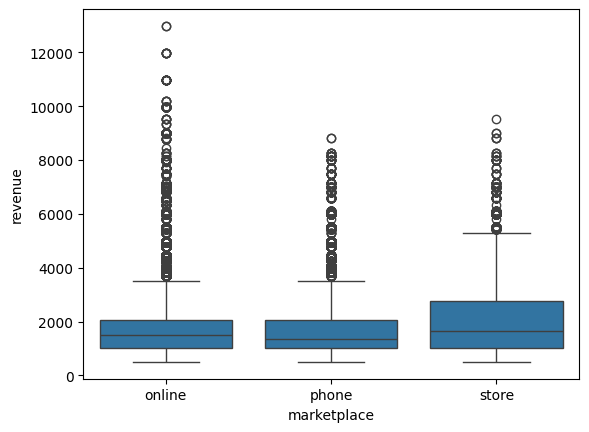

In [25]:
sns.boxplot(data=df_reg_main, x="marketplace", y="revenue")

<Axes: xlabel='marketplace', ylabel='profit'>

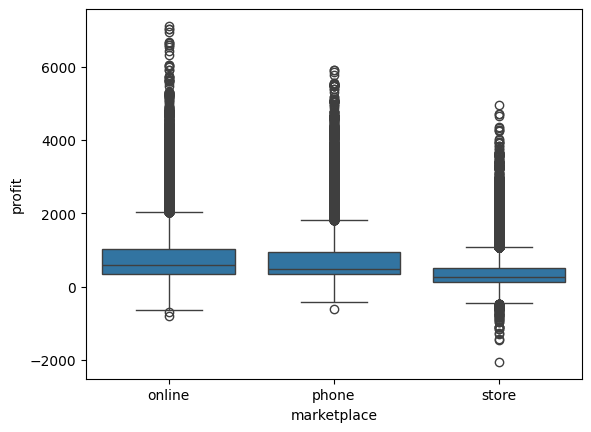

In [26]:
sns.boxplot(data=df_reg_main, x="marketplace", y="profit")

In [33]:
df_reg_main.loc[(df_reg_main['marketplace'] == 'store') & (df_reg_main['profit'] < 0)].sort_values(by='date', ascending=True)

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,region,marketplace,year_month
21786,2022-03-03,Tablet Basic,0.9,11,1,0,0,503.66,NaN,NaN,...,503.66,5540.26,499,5489,-4.66,-51.26,7.3,A,store,2022-3
21821,2022-03-09,Tablet Basic,0.9,9,1,0,0,507.59,NaN,NaN,...,507.59,4568.31,499,4491,-8.59,-77.31,6.3,A,store,2022-3
198125,2022-03-25,Tablet Basic,0.9,10,1,0,0,500.01,NaN,NaN,...,500.01,5000.10,499,4990,-1.01,-10.10,4.8,C,store,2022-3
198137,2022-03-26,Tablet Basic,0.9,9,1,0,0,520.62,NaN,NaN,...,520.62,4685.58,499,4491,-21.62,-194.58,5.3,C,store,2022-3
198138,2022-03-26,Tablet Basic,0.9,8,1,0,0,500.67,NaN,NaN,...,500.67,4005.36,499,3992,-1.67,-13.36,4.6,C,store,2022-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200748,2022-10-31,Tablet Basic,1.0,5,1,0,0,599.16,NaN,NaN,...,599.16,2995.80,499,2495,-100.16,-500.80,4.6,C,store,2022-10
97035,2022-10-31,Tablet Basic,1.0,3,1,0,0,539.16,NaN,NaN,...,539.16,1617.48,499,1497,-40.16,-120.48,3.9,B,store,2022-10
97036,2022-10-31,Tablet Basic,1.0,2,1,0,0,539.17,NaN,NaN,...,539.17,1078.34,499,998,-40.17,-80.34,3.1,B,store,2022-10
200751,2022-10-31,Tablet Basic,1.0,2,1,0,0,539.18,NaN,NaN,...,539.18,1078.36,499,998,-40.18,-80.36,3.0,C,store,2022-10
